In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import amfe
from pyfeti import utils
from amfe.contact import jenkins, Nonlinear_force_assembler, Create_node2node_force_object
import time
import scipy.sparse as sparse
import scipy
import sparse as sp
from scipy.optimize import minimize, root
from contpy import optimize as copt, frequency
import numdifftools as nd

def timing(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        print('{:s} function took {:.3f} ms'.format(f.__name__, (time2-time1)*1000.0))

        return ret
    return wrap

Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.

Warning! Using python in global path


In [2]:
# geometric properties
dimension= 2
width= 5.0
heigh = 1.0
init_gap_x = width - 0.2*width
init_gap_y = -heigh - 0.01*heigh


#mesh properties
x_divisions,y_divisions= 11,3


#-------------------------------------------------------------------------------------------------------------------------
# Creating mesh for 2 bodies
d1= utils.DomainCreator(width=width, heigh=heigh, 
                         x_divisions=x_divisions, y_divisions=y_divisions, 
                         domain_id=1, start_x=0.0, start_y=0.0)

mesh_file_1 = 'domain_1.msh'
d1.save_gmsh_file(mesh_file_1)
m = amfe.Mesh()
m.import_msh(mesh_file_1)


m1 = m.translation(np.array([0., 0.]))
m2 = m.translation(np.array([init_gap_x,init_gap_y]))


In [3]:

ax1 = amfe.plot2Dmesh(m1)
amfe.plot2Dmesh(m2,ax=ax1)
ax1.set_xlim([0,2.2*width])
ax1.set_ylim([-1.1*width,1.1*width])
#ax1.legend('off')

<IPython.core.display.Javascript object>

(-5.5, 5.5)

In [4]:
# Defining contact pairs
m1.split_in_groups()
m2.split_in_groups()


tol_radius = 5.0E-1
contact_12_tag = 4
contact_21_tag = 5

# contact pair 12
d1 = m1.get_submesh('phys_group',contact_12_tag)
d2 = m2.get_submesh('phys_group',contact_21_tag)

contact12 = amfe.contact.Contact(d1,d2,tol_radius=tol_radius)
print('Number of contact pairs = %i' %len(contact12.contact_elem_dict))

It was not possible to find a slave node for master node 0. Minimum distance is 4.000012e+00
It was not possible to find a slave node for master node 1. Minimum distance is 3.500014e+00
It was not possible to find a slave node for master node 2. Minimum distance is 3.000017e+00
It was not possible to find a slave node for master node 3. Minimum distance is 2.500020e+00
It was not possible to find a slave node for master node 4. Minimum distance is 2.000025e+00
It was not possible to find a slave node for master node 5. Minimum distance is 1.500033e+00
It was not possible to find a slave node for master node 6. Minimum distance is 1.000050e+00
It was not possible to find a slave node for master node 7. Minimum distance is 5.001000e-01
Number of contact pairs = 3


In [5]:
contact12.master_normal_dict

{8: array([0., 1., 0.]), 9: array([0., 1., 0.]), 10: array([0., 1., 0.])}

In [6]:
rho = 7.85E-9 # ton/mm
E = 2.10E5 # MPa = N/mm2
my_material_template = amfe.KirchhoffMaterial(E=E, nu=0.3, rho=rho, plane_stress=False)

component_dict = {1:{'mesh' : m1, 
                     'domain_tag':3,
                     'external_force_tag':2,
                     'external_force_direction':1,
                     'force_value':1.0,
                     'Dirichlet_tag':1,
                     'material' : my_material_template},
                   2:{'mesh': m2, 
                      'domain_tag':3,
                      'external_force_tag':1,
                      'external_force_direction':0,
                      'force_value':0,
                       'Dirichlet_tag':2,
                       'material' : my_material_template}}


ro=1.0E5
N0=0.0E0
k= 1.0E0
mu= 0.0
contact_dict = {'12' : {'contact' : contact12, 
                        'contact_pair_id' : (1,2),
                        'elem_type' : 'jenkins' , 
                        'elem_properties' : {'ro':ro,'N0':N0,'k':k, 'mu':mu}}}

In [7]:
from pyfeti.src.utils import DomainCreator, dict2dfmap, create_selection_operator, DofManager
def components2list(component_dict,dimension=3):
    K_list = []
    M_list = []
    f_list = []
    for domain_id, param_dict in component_dict.items():

        globals().update(param_dict)
        #print(param_dict)
        #print(locals())
        m = mesh 
        my_comp = amfe.MechanicalSystem()
        my_comp.set_mesh_obj(m)
        my_comp.set_domain(domain_tag,material)

        if dimension==3:

            if external_force_direction == 0:
                direction = np.array([1.,0.,0.])
            elif external_force_direction == 1:
                direction = np.array([0.,1.,0.])
            else:
                direction = np.array([0.,0.,1.])
                
        elif dimension==2:
            if external_force_direction == 0:
                direction = np.array([1.,0.])
            elif external_force_direction == 1:
                direction = np.array([0.,1.])
            

        my_comp.apply_neumann_boundaries(external_force_tag,force_value,direction)
        print('Number of nodes is equal to %i' %my_comp.mesh_class.no_of_nodes)

        K, f_ = my_comp.assembly_class.assemble_k_and_f()
        _, fext = my_comp.assembly_class.assemble_k_and_f_neumann()
        M = my_comp.assembly_class.assemble_m()


        try:
            connectivity = []
            for _,item in m.el_df.iloc[:, m.node_idx:].iterrows():
                connectivity.append(list(item.dropna().astype(dtype='int64')))
            m.el_df['connectivity'] = connectivity
        except:
            pass

        id_matrix = my_comp.assembly_class.id_matrix
        id_map_df = dict2dfmap(id_matrix)
        s = create_selection_operator(id_map_df,m.el_df)

        from pyfeti.src.linalg import Matrix
        K1 = Matrix(K,key_dict=s.selection_dict)
        M1 = Matrix(M,key_dict=s.selection_dict)


        # applying Dirichlet B.C.
        K1.eliminate_by_identity(Dirichlet_tag,1.0E15)
        M1.eliminate_by_identity(Dirichlet_tag,0.0)

        K_list.append(K1.data)
        M_list.append(M1.data)
        f_list.append(fext)
        
    return K_list, M_list, f_list
    
def list2global(K_list, M_list, f_list, alpha=1.0E-3, beta=1.0E-7):
   
    K_global = sparse.block_diag(K_list)
    M_global = sparse.block_diag(M_list)
    
    C_global = alpha*K_global + beta*M_global
    f_global = np.concatenate(f_list)
    f_global/=np.linalg.norm(f_global)

    return K_global.tocsc(),M_global.tocsc(),C_global.tocsc(),f_global


def create_map_local_domain_dofs_dimension(component_dict,dimension=3):
    map_local_domain_dofs_dimension = {}
    for domain_id, param_dict in component_dict.items():
        m_ = param_dict['mesh']
        map_local_domain_dofs_dimension[domain_id] = m_.no_of_nodes*dimension
    return map_local_domain_dofs_dimension

class SplitOperator():
    def __init__(self,map_local_domain_dofs_dimension):
        self.map_local_domain_dofs_dimension = map_local_domain_dofs_dimension
        
    def LinearOperator(self,u):
        u_list = []
        idx = 0
        for key, item in self.map_local_domain_dofs_dimension.items():
            try:
                u_list.append(u[idx:idx+item])
            except:
                u_list.append(u[idx:])
            idx = item
        return u_list
        
class Nonlinear_Force():
    def __init__(self,Fnl_obj_list):
        self.Fnl_obj_list = Fnl_obj_list
        
    def compute_force(self,u,X0=None):
        Fnl_obj_list = self.Fnl_obj_list
        for fnl_obj_item in Fnl_obj_list:
            try:
                output += fnl_obj_item.compute(u,X0)
            except:
                output = fnl_obj_item.compute(u,X0)

        return output
        
    def compute_jacobian(self,u,X0=None):
        Fnl_obj_list = self.Fnl_obj_list
        for fnl_obj_item in Fnl_obj_list:
            try:
                output += fnl_obj_item.Jacobian(u,X0)
            except:
                output = fnl_obj_item.Jacobian(u,X0)

        return output
    
    
def force_in_time(fext,time_points,omega):
    
    f_list = []
    for i in range(time_points):
        a = rate*np.sin(2.0*np.pi*i/time_points)
        f1 = a*fext
        f_list.append(f1)

    return np.array(f_list).T

In [8]:
K_list, M_list, f_list =components2list(component_dict,dimension=2)

K_global,M_global,C_global,f_global =  list2global(K_list, M_list, f_list,alpha = 1.0E-2, beta = 1.0E-4)

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 20 elements and 66 dofs.
Time taken for preallocation: 0.00 seconds.
Number of nodes is equal to 33
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 20 elements and 66 dofs.
Time taken for preallocation: 0.00 seconds.
Number of nodes is equal to 33


/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


In [9]:
# solving Eigenvalue problem for problem change of basis
K_global_inv = sparse.linalg.splu(K_global)
D = sparse.linalg.LinearOperator(shape=K_global.shape, matvec = lambda x : K_global_inv.solve(M_global.dot(x)))

modes = 30
val, Phi = sparse.linalg.eigs(D,k=modes)
Phi = Phi.real
normalizeit = True
if normalizeit:
    for i in range(modes):
        vi = Phi[:,i]
        Phi[:,i] = vi/np.linalg.norm(vi)  

In [10]:
map_local_domain_dofs_dimension = create_map_local_domain_dofs_dimension(component_dict,dimension=2)

In [11]:
SO = SplitOperator(map_local_domain_dofs_dimension)

In [12]:
from matplotlib import animation, rc
u_list = SO.LinearOperator(Phi[:,1])
fig, ax2 = plt.subplots(1,1)

mesh_list = [m1,m2]
factor=6.0
def update(factor=6.0):
    i=0
    ax2.clear()
    for key, mesh_dict_ in component_dict.items():
        me = mesh_dict_['mesh']
        #me = mesh_list[i]
        p1, _ = amfe.plotDeformQuadMesh(me.connectivity,me.nodes,u_list[i],factor=factor,ax=ax2,color_id=1)
        i+=1

    ax2.set_xlim([0,2.2*width])
    ax2.set_ylim([-1.1*width,1.1*width])
    ax2.legend('off')
    
    
#update(10)
frame_list = list(map(lambda x : 2.0*np.sin(2.0*np.pi*x/100),range(100)))
anim = animation.FuncAnimation(fig, update,
                               frames=frame_list, interval=20)

<IPython.core.display.Javascript object>

In [13]:
Fnl_obj_list = []
for contact_key,contact_item in contact_dict.items():
    bodies_contact_id = contact_item['contact_pair_id']
    contact_12 = contact_item['contact']
    elem_type = contact_item['elem_type']
    elem_properties = contact_item['elem_properties']
    create_obj_1 = Create_node2node_force_object(contact12,bodies_contact_id,elem_type,elem_properties,dimension,map_local_domain_dofs_dimension)
    Fnl_obj_list.append(create_obj_1.assemble_nonlinear_force())
    

In [46]:
from contpy import optimize as copt, frequency, operators

nH = 1
omega = 1.0
time_points = nH*25
rate = 1.0E2

ndofs = K_global.shape[0]
Q = frequency.assemble_hbm_operator(ndofs,number_of_harm=nH ,n_points=time_points) # bases of truncaded Fourier
nonlinear_force_obj = Nonlinear_Force(Fnl_obj_list)
AFT  = operators.Nonlinear_Force_AFT(Q,nonlinear_force_obj)
Z = lambda w : frequency.create_Z_matrix(K_global,C_global,M_global,f0= w/(2.0*np.pi),nH=nH, static=False)
Zw = Z(omega)
Zw_real = copt.complex_matrix_to_real_block(Zw)
force_global_in_time = force_in_time(f_global,time_points,omega)
force_global_ = Q.H.dot(force_global_in_time)

In [79]:
def Residual_and_Jac_in_real_block(u_real):
    u_ = copt.real_array_to_complex(u_real)
    fnl_complex_eval, Jnl_eval_1, Jnl_eval_conj_1 = AFT.compute_force_and_jac(u_)
    J_block_real = copt.complex_matrix_to_real_block(Jnl_eval_1, Jnl_eval_conj_1)
    J = Zw_real - J_block_real
    R = Zw.dot(u_) - force_global_ - fnl_complex_eval
    R_real = copt.complex_array_to_real(R)
    return R_real, J
    
    

In [80]:
Zw_inv = sparse.linalg.splu(Zw)
u__initial = Zw_inv.solve(force_global_)
u__inital_real = copt.complex_array_to_real(u__initial)
u__inital_real = 0.0*u__inital_real

In [81]:
sol2 = copt.LevenbergMarquardt(Residual_and_Jac_in_real_block,u__inital_real,method=None,jac=True,maxiter=200)
u_sol =   copt.real_array_to_complex(sol2.x)
u_sol_time = Q.dot(u_sol)

step  1: |f|:   345.505 tau:    2e-20 rho: -9.24e+04
step  2: |f|:   345.505 tau:    8e-20 rho: -9.24e+04
step  3: |f|:   345.505 tau:  6.4e-19 rho: -9.24e+04
step  4: |f|:   345.505 tau: 1.02e-17 rho: -9.24e+04
step  5: |f|:   345.505 tau: 3.28e-16 rho: -9.24e+04
step  6: |f|:   345.505 tau:  2.1e-14 rho: -9.24e+04
step  7: |f|:   345.505 tau: 2.68e-12 rho: -9.24e+04
step  8: |f|:   345.505 tau: 6.87e-10 rho: -9.23e+04
step  9: |f|:   345.505 tau: 3.52e-07 rho: -8.8e+04
step 10: |f|:   345.505 tau:  0.00036 rho:     -225
step 11: |f|:   224.878 tau:  0.00012 rho:     1.05
step 12: |f|:   212.296 tau:    4e-05 rho:     1.62
step 13: |f|:   196.438 tau: 1.33e-05 rho:     1.66
step 14: |f|:   184.963 tau: 4.45e-06 rho:     1.41
step 15: |f|:   184.963 tau:  8.9e-06 rho:    -0.75
step 16: |f|:   182.322 tau: 2.97e-06 rho:      1.5
step 17: |f|:   182.322 tau: 5.93e-06 rho:    -19.2
step 18: |f|:   182.322 tau: 2.37e-05 rho:    -9.95
step 19: |f|:   182.322 tau:  0.00019 rho:     -1.8
step

<IPython.core.display.Javascript object>


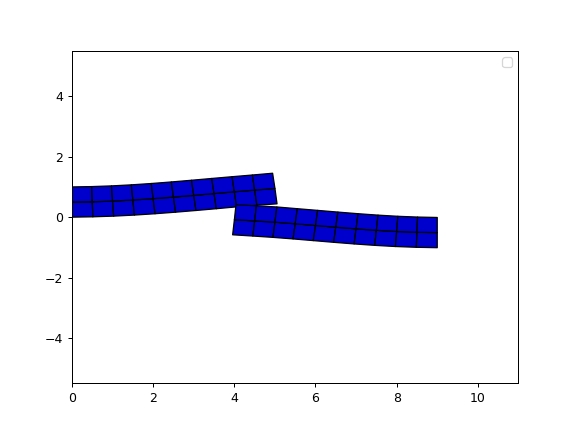

In [82]:
from matplotlib import animation, rc
u_list = SO.LinearOperator(u_sol_time)
fig2, ax2 = plt.subplots(1,1)

mesh_list = [m1,m2]
factor=6.0
def update_HBM(j,factor=6.0):
    i=0
    ax2.clear()
    for key, mesh_dict_ in component_dict.items():
        me = mesh_dict_['mesh']
        #me = mesh_list[i]
        p1, _ = amfe.plotDeformQuadMesh(me.connectivity,me.nodes,u_list[i].T[j],factor=factor,ax=ax2,color_id=1)
        i+=1

    ax2.set_xlim([0,2.2*width])
    ax2.set_ylim([-1.1*width,1.1*width])
    ax2.legend('off')
    
    
#update(10)
anim = animation.FuncAnimation(fig2, update_HBM,
                               frames=range(time_points), interval=20)

In [83]:
V = Phi[:,0:2]
Zw_mode = V.T@Zw@V
Zw_mode_real = copt.complex_matrix_to_real_block(Zw_mode)
def Residual_and_Jac_mode(q_real):
    q_complex = copt.real_array_to_complex(q_real)
    u_ = V.dot(q_complex)
    fnl_complex_eval, Jnl_eval_1, Jnl_eval_conj_1 = AFT.compute_force_and_jac(u_)
    J_block_real = copt.complex_matrix_to_real_block(V.T@Jnl_eval_1@V, V.T@Jnl_eval_conj_1@V)
    J = Zw_mode_real  - J_block_real
    R = Zw.dot(u_) - force_global_ - fnl_complex_eval
    VTR = V.T.dot(R)
    R_real = copt.complex_array_to_real(VTR)
    return R_real, J

In [97]:
q_complex = V.T.dot(u_sol)
#q_complex = np.linalg.solve(Zw_mode,V.T@force_global_)
#q_complex = V.T.dot(u__initial)
q_real_init = copt.complex_array_to_real(q_complex )


In [98]:
sol2_q = copt.LevenbergMarquardt(Residual_and_Jac_mode,q_real_init,method=None,jac=True,maxiter=200)

#u = Vq
q_sol_complex = copt.real_array_to_complex(sol2_q)
u_sol_mode =  u_ = V.dot(q_complex)
u_sol_time = Q.dot(u_sol_mode)

step  1: |f|:    15.001 tau: 3.33e-21 rho:    0.988
step  2: |f|: 0.00748634 tau: 1.11e-21 rho:        1
step  3: |f|: 5.75646e-05 tau:  3.7e-22 rho:        1
small step
Warning! Could not convert to complex number


<IPython.core.display.Javascript object>


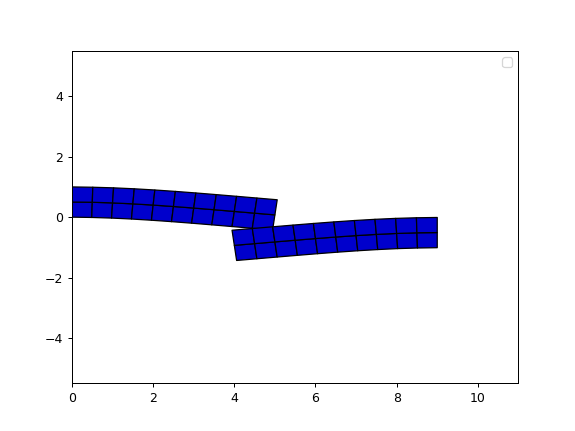

In [99]:
from matplotlib import animation, rc
u_list = SO.LinearOperator(u_sol_time)
fig3, ax2 = plt.subplots(1,1)

mesh_list = [m1,m2]
factor=6.0
def update_HBM_modes(j,factor=6.0):
    i=0
    ax2.clear()
    for key, mesh_dict_ in component_dict.items():
        me = mesh_dict_['mesh']
        #me = mesh_list[i]
        p1, _ = amfe.plotDeformQuadMesh(me.connectivity,me.nodes,u_list[i].T[j],factor=factor,ax=ax2,color_id=1)
        i+=1

    ax2.set_xlim([0,2.2*width])
    ax2.set_ylim([-1.1*width,1.1*width])
    ax2.legend('off')
    
    
#update(10)
anim = animation.FuncAnimation(fig3, update_HBM_modes,frames=range(time_points), interval=20)

<IPython.core.display.Javascript object>


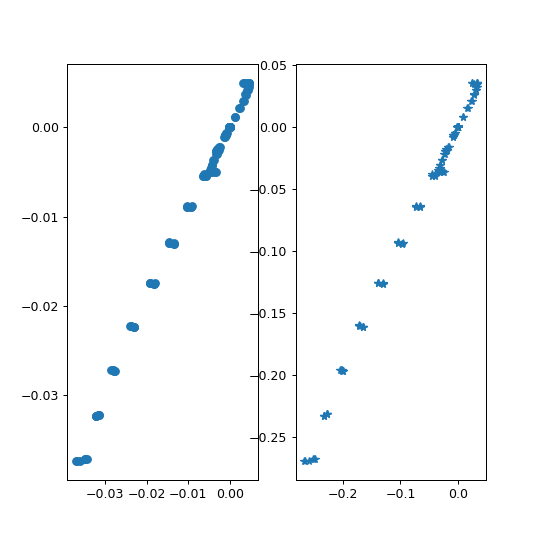

In [100]:
fig4, (ax41, ax42) = plt.subplots(1,2, figsize=(6,6))
ax41.plot(u_sol.real,u_sol_mode.real,'o')
ax42.plot(u_sol.imag,u_sol_mode.imag,'*')
plt.show()